In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from hyppo.independence import Dcorr
from lol import LOL
from sklearn.utils import check_X_y
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

from nilearn import datasets, plotting
import nibabel as nib

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
datadir = Path("/mnt/ssd3/ronan/data")
tag = "_min_rank-ZG3"  #'_max_rank-ZG2'
gccadir = datadir / f"gcca_05-26-10:39{tag}"  # f'gcca_05-17-18:27{tag}' #
dmap_dir = datadir / f"dmap_09-04_mean-aligned"

<IPython.core.display.Javascript object>

In [3]:
data = "dmap"

# script code
if data == "gcca":
    flag = "_gcca"
    ftype = "h5"
    source_dir = gccadir
elif data == "dmap":
    flag = "_dmap"
    ftype = "npy"
    source_dir = dmap_dir
else:
    raise ValueError(f"{data} invalid data key")
groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=data
)

<IPython.core.display.Javascript object>

In [4]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()
external_dir = Path("../data/external")


def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed=1,
    title=None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(
        n_embed,
        4,
        subplot_kw={"projection": "3d"},
        figsize=(res_scale * 5, res_scale * n_embed),
    )
    if n_embed == 1:
        axes = [axes]

    plt.subplots_adjust(wspace=0, hspace=0)

    for i, ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / "lh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[: len(cortex_left)]

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu_r",
            axes=ax[0],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu_r",
            view="medial",
            axes=ax[1],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        cortex_right = nib.freesurfer.read_label(external_dir / "rh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left) :]

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=False,
            cmap="RdBu_r",
            axes=ax[2],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=colorbar,
            cmap="RdBu_r",
            view="medial",
            axes=ax[3],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f"{str(save_path)}.png", format="png", bbox_inches="tight")
    else:
        return fig


#         plt.show()
#         plt.close(fig)


def make_cbar(vmax, save_path=None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu_r
    else:
        cmap = mpl.cm.Blues_R
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    # cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")

    # cb1.set_clim(vmin, vmax)
    # cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f"{str(save_path)}.pdf", bbox_inches="tight")
    plt.close(fig)

<IPython.core.display.Javascript object>

## individuals

In [7]:
SAVE = False
COLORBAR = True
n_embed = 1

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

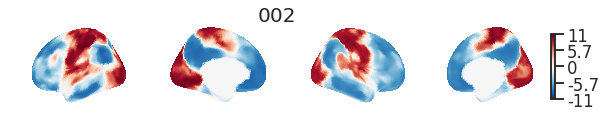

<Figure size 432x288 with 0 Axes>

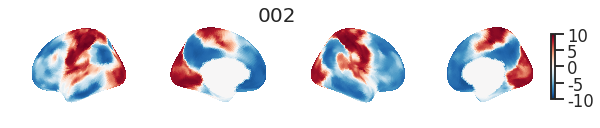

<Figure size 432x288 with 0 Axes>

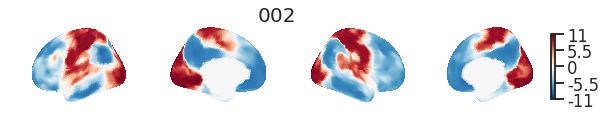

<Figure size 432x288 with 0 Axes>

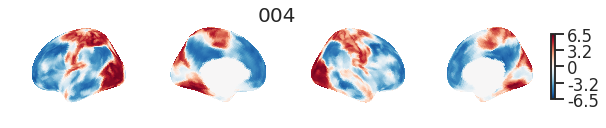

<Figure size 432x288 with 0 Axes>

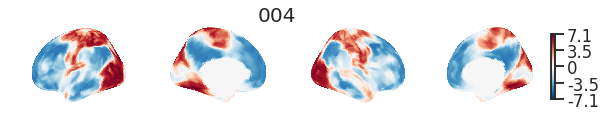

<Figure size 432x288 with 0 Axes>

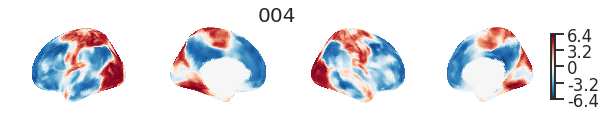

<Figure size 432x288 with 0 Axes>

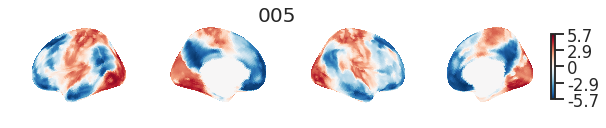

<Figure size 432x288 with 0 Axes>

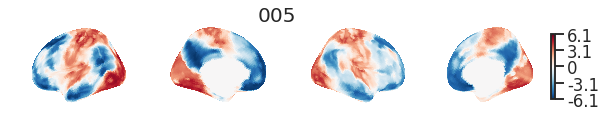

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [8]:
Xs = np.vstack([np.stack(g) for g in groups])
subj_ids = np.hstack(subjs)
idx = np.argsort(subj_ids)
Xs = Xs[idx]
subj_ids = subj_ids[idx]


for X, subj in zip(Xs, subj_ids):
    title = subj
    visualize_embeddings(
        X[:, :n_embed],
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        # vmax=vmax,
        title=title,
    )
    plt.show()

## mean aligned

In [ ]:
SAVE = False
COLORBAR = True
n_embed = 3

In [ ]:
means = []
for group in groups:
    ## Select Gradient(s)
    X = np.stack(group)
    X = X.mean(axis=0) / X.std(axis=0, ddof=1)
    means.append(X[:, :n_embed])

for mean, name in zip(means, labels):
    if COLORBAR:
        vmax = np.max(np.abs(mean))
    if SAVE:
        title = False
    else:
        title = f"{name}"
    visualize_embeddings(
        mean,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    plt.show()

## mean aligned, normed

In [ ]:
SAVE = False
COLORBAR = True
n_embed = 3

<Figure size 432x288 with 0 Axes>

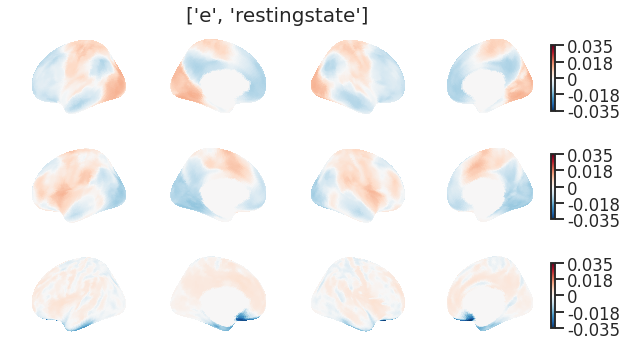

<Figure size 432x288 with 0 Axes>

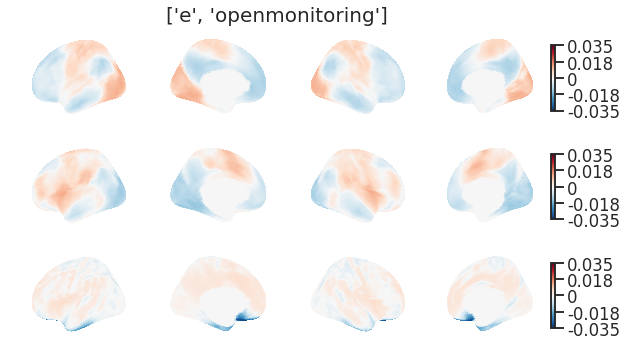

<Figure size 432x288 with 0 Axes>

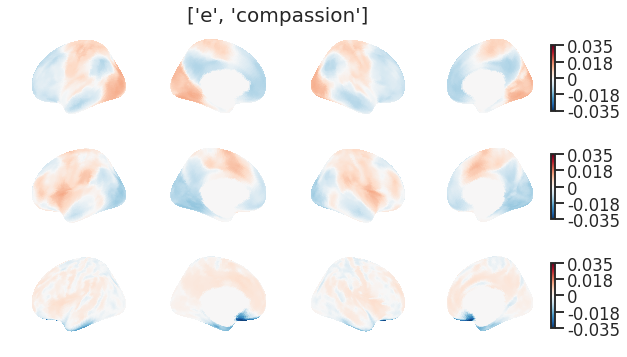

<Figure size 432x288 with 0 Axes>

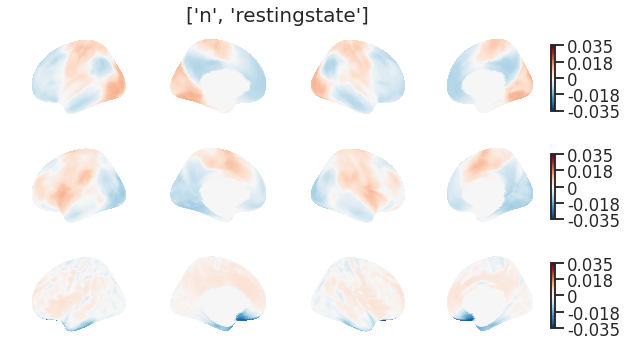

<Figure size 432x288 with 0 Axes>

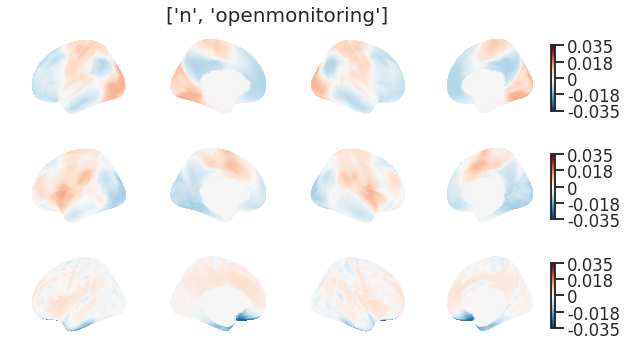

<Figure size 432x288 with 0 Axes>

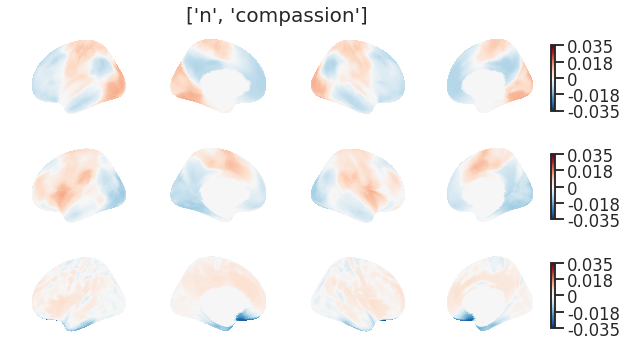

<IPython.core.display.Javascript object>

In [6]:
means = []
for group in groups:
    ## Select Gradient(s)
    X = np.stack(group)
    X = (X / np.linalg.norm(X, axis=1, keepdims=True)).mean(axis=0)
    means.append(X[:, :n_embed])

if COLORBAR:
    vmax = np.max(np.abs(means))

for mean, name in zip(means, labels):
    if SAVE:
        title = False
    else:
        title = f"{name}"
    visualize_embeddings(
        mean,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    plt.show()